In [1]:
import ampal
import isambard
import isambard.specifications as specifications
import isambard.modelling as modelling
import isambard.optimisation as optimisation
import isambard.optimisation.evo_optimizers as ev_opts
from isambard.optimisation.evo_optimizers import Parameter
import budeff

import matplotlib.pyplot as plt
import numpy as np
import itertools
from pprint import pprint
import nglview as nv
from contextlib import redirect_stdout

%matplotlib inline

In [2]:
def show_ball_and_stick(ampal):
    view = nv.show_text(ampal.pdb)
    view.add_ball_and_stick()
    view.remove_cartoon()
    return view

In [3]:
class APHomoDimer(specifications.CoiledCoil):
    """Specification for creating anti-parallel, homodimeric coiled coils."""
    
    oligomeric_state = 2
    
    # The only thing that we need to define is a new `__init__` method, which defines
    # how the class is created. We get all the rest of the functionality off the
    # parent class `CoiledCoil`.
    def __init__(self, helix_length, radius, pitch, phica, zshift):
        # To kick everything off, this class runs the standard setup of the `CoiledCoil`
        # class, which gives our class all of the same attributes and methods. The
        # `super` function gives us access to the parent class. As we want to modify
        # some of the parameters before building the model, we set `auto_build` to false
        super().__init__(self.oligomeric_state, auto_build=False)
        
        # Next, we redefine the relevant default values that `CoiledCoil` has set. As
        # we have 2 helices, we have 2 values for each of these, but in this case they
        # are the same as we're making a homodimer
        self.aas = [helix_length, helix_length]
        self.major_radii = [radius, radius]
        self.major_pitches = [pitch, pitch]
        self.z_shifts = [0, zshift]
        self.phi_c_alphas = [phica, phica]
        
        # We need to set the orientation of the helices to be anti-parallel, so one
        # needs to have a +1 orientation and the other needs a -1 orientation
        self.orientations = [1, -1]

        # Now we've redefined these values, we need to build the model from these
        # parameters. We can do this using the build method, which comes from
        # `CoiledCoil`
        self.build()

In [4]:
REGISTER_ADJUST = {
    'a': 0,
    'b': 102.8,
    'c': 205.6,
    'd': 308.4,
    'e': 51.4,
    'f': 154.2,
    'g': 257
}

In [5]:
sequences = ['GEIAALKQEIAALKKENAALKWEIAALKQGYY', 'GEIAALKQEIAALKKENAALKWEIAALKQGYY']

In [6]:
def get_bude_total_energy(ampal_object):
    return budeff.get_internal_energy(ampal_object).total_energy

In [7]:
parameters = [
    optimisation.Parameter.static('Helix Length', 32),
    optimisation.Parameter.dynamic('Radius', 5.0, 1.0),
    optimisation.Parameter.dynamic('Pitch', 200, 60),
    optimisation.Parameter.dynamic('PhiCA', REGISTER_ADJUST['f'], 27),
    optimisation.Parameter.dynamic('ZShift', 10, 10),
]

In [8]:
default_values = [x.default_value for x in parameters]
print(default_values)

[32, 5.0, 200, 154.2, 10]


### Genetic Algorithm

In [9]:
opt_ga = ev_opts.GA(APHomoDimer, sequences, parameters, get_bude_total_energy)

In [10]:
opt_ga.run_opt(100, 30, cores=8)

gen	evals	avg    	std    	min     	max     
0  	63   	-852.63	48.8656	-939.236	-726.015
1  	71   	-891.735	25.2442	-939.236	-847.317
2  	74   	-911.109	16.9095	-954.033	-882.489
3  	58   	-920.325	14.6128	-954.033	-895.159
4  	78   	-928.688	10.5793	-956.171	-910.406
5  	73   	-934.376	9.0214 	-956.999	-917.513
6  	65   	-939.892	8.39191	-959.072	-925.032
7  	72   	-942.588	7.37237	-959.072	-927.775
8  	83   	-948.541	5.54961	-959.072	-939.04 
9  	74   	-951.16 	4.85365	-959.072	-942.626
10 	65   	-954.412	2.7779 	-959.072	-947.147
11 	82   	-956.134	1.26074	-959.072	-953.014
12 	60   	-956.88 	0.98517	-959.072	-955.079
13 	62   	-957.65 	0.79396	-959.226	-956.174
14 	82   	-958.263	0.587885	-959.452	-957.114
15 	67   	-958.559	0.467211	-959.604	-957.479
16 	74   	-958.857	0.359873	-959.604	-958.13 
17 	83   	-959.133	0.269174	-959.675	-958.677
18 	74   	-959.339	0.169985	-959.675	-958.944
19 	74   	-959.396	0.140397	-959.675	-959.072
20 	65   	-959.456	0.111488	-959.675	-959.238
21 	7

In [11]:
optimized_model_ga = opt_ga.best_model

In [12]:
budeff.get_internal_energy(optimized_model_ga).total_energy

-959.7525721987486

In [13]:
funnel_data_ga = opt_ga.make_energy_funnel_data()

In [14]:
xs = [x[0] for x in funnel_data_ga]
ys = [x[1] for x in funnel_data_ga]
zs = [x[2] for x in funnel_data_ga]

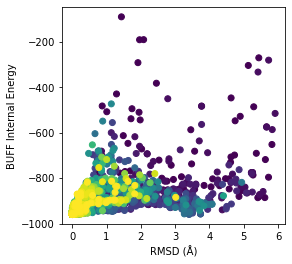

In [15]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('2_ga.png')

In [16]:
f = open('2_d_CC-Di_ap-optimized-model-ga.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_ga.pdb)

### Differential Evolution

In [17]:
opt_de = ev_opts.DE(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [18]:
opt_de.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-818.475	87.5864	-949.086	-494.611
1  	100  	-868.659	43.8586	-949.086	-703.828
2  	100  	-889.447	26.9618	-949.086	-804.304
3  	100  	-896.97 	22.3195	-949.086	-813.369
4  	100  	-902.195	20.2518	-949.086	-833.301
5  	100  	-909.574	17.4858	-949.38 	-868.581
6  	100  	-915.544	16.1138	-955.936	-873.925
7  	100  	-919.222	15.7871	-955.936	-879.564
8  	100  	-923.955	15.1614	-957.681	-879.564
9  	100  	-928.435	15.2979	-963.632	-879.564
10 	100  	-931.622	13.9554	-963.632	-898.245
11 	100  	-935.885	12.8825	-963.632	-903.629
12 	100  	-939.408	12.0673	-963.632	-903.629
13 	100  	-943.195	11.5491	-966.06 	-913.923
14 	100  	-946.329	9.92633	-966.06 	-919.715
15 	100  	-949.219	9.28308	-967.338	-922.336
16 	100  	-951.438	8.01372	-967.71 	-928.464
17 	100  	-955.301	6.81281	-973.782	-935.335
18 	100  	-957.529	6.48673	-973.782	-943.847
19 	100  	-959.195	5.87919	-973.782	-943.847
20 	100  	-961.678	5.26343	-973.782	-948.759
21 	100  	

In [19]:
optimized_model_de = opt_de.best_model
budeff.get_internal_energy(optimized_model_de).total_energy

-976.4517272873506

In [20]:
funnel_data_de = opt_de.make_energy_funnel_data()

In [21]:
xs = [x[0] for x in funnel_data_de]
ys = [x[1] for x in funnel_data_de]
zs = [x[2] for x in funnel_data_de]

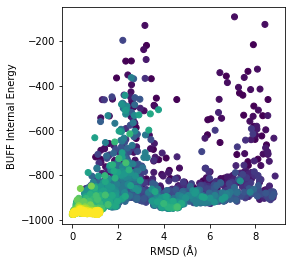

In [22]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('2_de.png')

In [23]:
f = open('2_d_CC-Di_ap-optimized-model-de.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_de.pdb)

### Particle Swarm Optimisation

In [24]:
opt_pso = ev_opts.PSO(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [25]:
opt_pso.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max    
0  	100  	-708.379	196.607	-930.786	316.082
1  	69   	-650.751	262.439	-967.109	316.082
2  	55   	-678.952	230.795	-967.109	6.95937
3  	72   	-748.161	167.855	-932.481	-145.487
4  	88   	-707.67 	210.701	-932.481	54.6026 
5  	60   	-696.545	226.499	-963.144	54.6026 
6  	41   	-732.402	205.337	-963.144	54.6026 
7  	61   	-760.298	187.012	-963.144	31.0358 
8  	80   	-784.148	150.517	-967.348	-269.161
9  	70   	-717.184	225.934	-975.069	46.1176 
10 	39   	-714.199	225.719	-975.069	46.1176 
11 	42   	-731.464	212.135	-975.069	34.2661 
12 	49   	-734.554	222.486	-975.069	34.2661 
13 	59   	-753.572	176.022	-975.069	-24.8224
14 	48   	-754.101	171.65 	-975.069	-24.8224
15 	46   	-762.737	181.558	-975.069	-24.8224
16 	52   	-754.464	178.991	-975.069	-24.8224
17 	50   	-760.447	157.298	-975.069	-271.647
18 	45   	-760.93 	158.451	-974.868	-271.647
19 	68   	-671.283	234.699	-974.868	67.5444 
20 	70   	-616.545	266.178	-974.868	67.5444 
21 	76   	-678

In [26]:
optimized_model_pso = opt_pso.best_model
budeff.get_internal_energy(optimized_model_pso).total_energy

-975.0689598882204

In [27]:
funnel_data_pso = opt_pso.make_energy_funnel_data()

In [28]:
xs = [x[0] for x in funnel_data_pso]
ys = [x[1] for x in funnel_data_pso]
zs = [x[2] for x in funnel_data_pso]

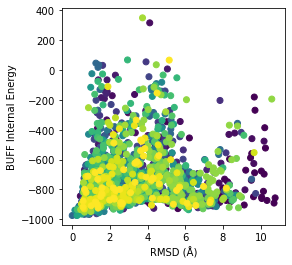

In [29]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('2_pso.png')

In [30]:
f = open('2_d_CC-Di_ap-optimized-model-pso.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_pso.pdb)

### Covariance Matrix Adaptive Evolutionary Strategy

In [31]:
opt_cmaes = ev_opts.CMAES(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [32]:
opt_cmaes.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-765.108	102.491	-944.883	-467.637
1  	100  	-816.429	78.307 	-919.087	-540.214
2  	100  	-825.22 	96.3026	-916.098	-462.21 
3  	100  	-830.288	99.0104	-931.56 	-463.914
4  	100  	-864.373	74.9913	-949.459	-442.798
5  	100  	-893.146	30.0257	-929.663	-734.965
6  	100  	-900.436	24.5129	-942.671	-804.846
7  	100  	-884.256	71.0507	-940.214	-541.769
8  	100  	-906.12 	25.2911	-954.685	-816.041
9  	100  	-912.6  	23.3089	-951.648	-840.118
10 	100  	-919.659	22.0955	-952.907	-841.336
11 	100  	-916.057	24.2729	-947.841	-835.682
12 	100  	-920.778	21.165 	-958.421	-856.558
13 	100  	-924.987	20.6877	-955.458	-860.164
14 	100  	-925.814	20.0391	-949.67 	-880.731
15 	100  	-931.171	20.1522	-949.77 	-869.139
16 	100  	-935.089	18.4695	-948.262	-861.356
17 	100  	-941.876	12.6304	-949.298	-869.962
18 	100  	-941.919	12.9879	-949.659	-888.25 
19 	100  	-937.696	20.9206	-950.388	-861.37 
20 	100  	-942.917	13.0785	-950.232	-878.653
21 	100  	

In [33]:
optimized_model_cmaes = opt_cmaes.best_model
budeff.get_internal_energy(optimized_model_cmaes).total_energy

-958.4210690040757

In [34]:
funnel_data_cmaes = opt_cmaes.make_energy_funnel_data()

In [35]:
xs = [x[0] for x in funnel_data_cmaes]
ys = [x[1] for x in funnel_data_cmaes]
zs = [x[2] for x in funnel_data_cmaes]

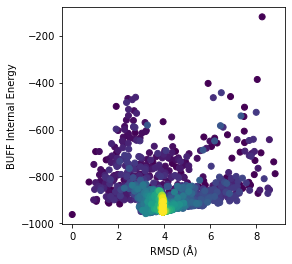

In [36]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('2_cmaes.png')

In [37]:
f = open('2_d_CC-Di_ap-optimized-model-cmaes.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_cmaes.pdb)